Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import cv2
import json
from pprint import pprint
import random

Helper Functions

In [15]:
def extract_id(file_name: str) -> str | None:
    """
    Give a file name such as 'A_P000001_PAS_CPG.tif',
    Extract the file ID: 'A_P000001' using regular expression
    """
    match = re.match(r"([A-Z]_P\d+)_", file_name, re.IGNORECASE)

    if match:
        return match.group(1)
    else:
        return None


def cell_mask_to_rgb(cell_mask: np.ndarray) -> np.ndarray:
    """For visualization purposes
    Convert 2D cell mask to an RGB image
    2D cell mask:
    1 - Lympchoyte centroids
    2 - Monocytes centroids
    RGB image:
    Green - Lympchoyte centroids
    Blue - Monocytes centroids
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    cell_mask = cv2.dilate(cell_mask, kernel, iterations=1)
    rgb_mask = np.zeros(
        (cell_mask.shape[0], cell_mask.shape[1], 3), dtype=np.uint8
    )
    rgb_mask[cell_mask == 1] = (0, 255, 0)
    rgb_mask[cell_mask == 2] = (0, 0, 255)
    return rgb_mask

Visualize 50 random patches

In [ ]:
# Specify data folders

# Folder containing image patches
patch_image_dir = "/home/u1910100/Documents/Monkey/patches_256/images"
# Folder containing cell masks
cell_mask_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/masks"
)
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/json"
)


# Visualize 50 random patches
file_names = os.listdir(patch_image_dir)
files_sample = random.sample(file_names, 50)

for name in files_sample:
    name_without_ext = os.path.splitext(name)[0]

    # Get path to files
    patch_image_path = os.path.join(
        patch_image_dir, f"{name_without_ext}.npy"
    )
    cell_mask_path = os.path.join(
        cell_mask_dir, f"{name_without_ext}.npy"
    )
    json_path = os.path.join(json_dir, f"{name_without_ext}.json")

    # load RGB patch and cell mask
    image_patch = np.load(patch_image_path)
    cell_mask = np.load(cell_mask_path)
    # Convert cell mask to RGB image for visualization
    rgb_cell_mask = cell_mask_to_rgb(cell_mask)

    # load json file
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    # Output
    pprint(name)
    # pprint(annotations)
    fig, axes = plt.subplots(1, 3, figsize=(17, 17))
    axes[0].imshow(image_patch)
    axes[0].title.set_text("RGB Patch")
    axes[1].imshow(rgb_cell_mask)
    axes[1].title.set_text("Cell Mask")
    axes[2].imshow(image_patch, alpha=0.5)
    axes[2].imshow(rgb_cell_mask, alpha=0.5)
    axes[2].title.set_text("Cell Mask overlay on RGB Patch")
    plt.show()

Count cells

In [ ]:
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_256/annotations/json"
)
file_names = os.listdir(json_dir)

lymphocyte_count = 0
monocytes_count = 0

for name in file_names:
    json_path = os.path.join(json_dir, name)
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    lymph_coords = annotations["lymphocytes"]
    mono_coords = annotations["monocytes"]

    lymphocyte_count += len(lymph_coords)
    monocytes_count += len(mono_coords)


print(f"lympho count = {lymphocyte_count}")
print(f"mono count = {monocytes_count}")

Visualize Dataloader

In [6]:
%reset -f
from monkey.data.dataset import get_dataloaders
from monkey.data.data_utils import imagenet_denormalise
from monkey.config import TrainingIOConfig
import numpy as np
import matplotlib.pyplot as plt

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)

train_loader, val_loader = get_dataloaders(
    IOconfig, val_fold=1, task=1, batch_size=1, disk_radius=9
)

['B_P000012_26432_10976_26688_11232']


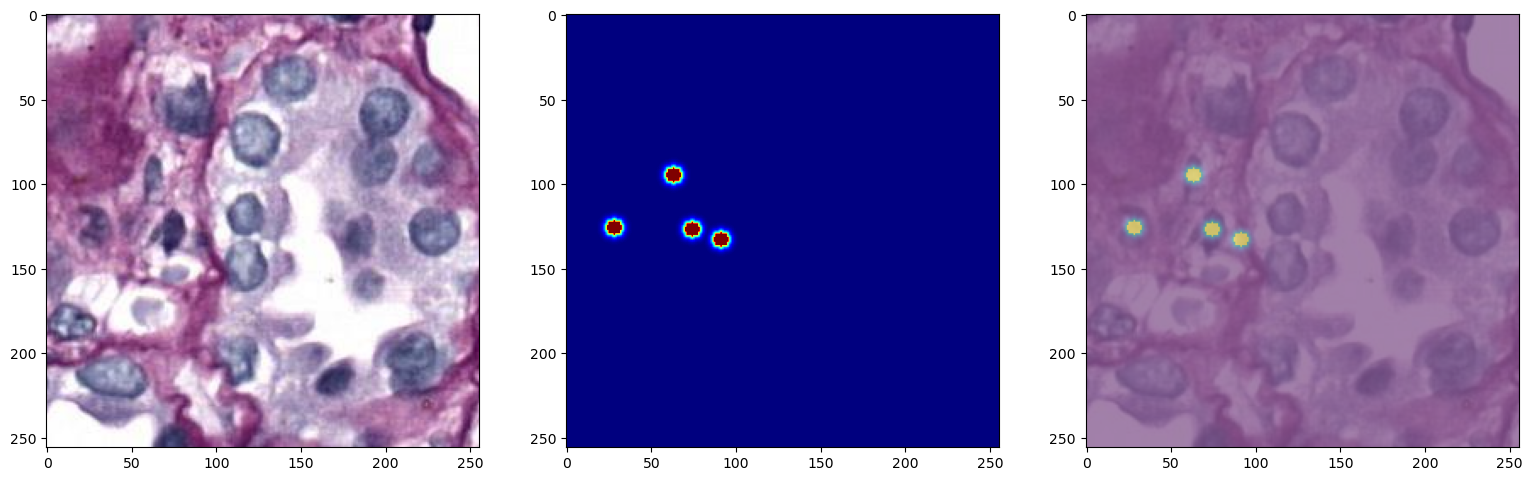

In [23]:
data = next(iter(val_loader))
print(data["id"])
image = data["image"][0].numpy()
mask = data["mask"][0][0].numpy()

image = np.moveaxis(image, 0, 2)
fig, axes = plt.subplots(1, 3, figsize=(19, 19))
axes[0].imshow(image)
axes[1].imshow(mask, cmap="jet")
axes[2].imshow(image, alpha=0.5)
axes[2].imshow(mask, alpha=0.5)
plt.show()